<a href="https://colab.research.google.com/github/robitussin/CCDATSCL_EXERCISES/blob/main/Exercise2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 2

<img src="https://vsqfvsosprmjdktwilrj.supabase.co/storage/v1/object/public/images/insights/1753644539114-netflix.jpeg"/>


In this activity , you will explore two fundamental preprocessing techniques used in data science and machine learning: feature scaling and discretization (binning).

These techniques are essential when working with datasets that contain numerical values on very different scales, or continuous variables that may be more useful when grouped into categories.


We will use a subset of the Netflix Movies and TV Shows dataset, which contains metadata such as release year, duration, ratings, and other attributes of titles currently or previously available on Netflix. Although the dataset is not originally designed for numerical modeling, it contains several features suitable for preprocessing practice—such as:
-Release Year
-Duration (in minutes)
-Number of Cast Members
-Number of Listed Genres
-Title Word Count

In this worksheet, you will:
- Load and inspect the dataset
- Select numerical features for scaling
- Apply different scaling techniques
- Min–Max Scaling
- Standardization
- Robust Scaling
- Perform discretization (binning)
- Equal-width binning
- Equal-frequency binning
- Evaluate how scaling affects machine learning performance, using a simple KNN

In [1]:
import numpy as np
import pandas as pd
import os
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.mode.copy_on_write = True

c:\Users\Virus5600\miniconda3\envs\com222\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Setup and Data Loading



Load the Netflix dataset into a DataFrame named df.

In [2]:
# Download latest version
path = kagglehub.dataset_download("shivamb/netflix-shows")

print("Path to dataset files:", path)

if os.path.isdir(path):
  print(True)

contents = os.listdir(path)
contents

mydataset = path + "/" + contents[0]
mydataset

df = pd.read_csv(mydataset)

Path to dataset files: C:\Users\Virus5600\.cache\kagglehub\datasets\shivamb\netflix-shows\versions\5
True


## 2. Data Understanding

Store the dataset’s column names in a variable called cols.

In [3]:
# put your answer here
cols = df.columns.tolist()
print(cols)

['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added', 'release_year', 'rating', 'duration', 'listed_in', 'description']


Store the shape of the dataset as a tuple (rows, columns) in shape_info.

In [4]:
# put your answer here
shape_info = df.shape
print(shape_info)

(8807, 12)


## 3. Data Cleaning
Count missing values per column and save to missing_counts.

In [5]:
# put your answer here
missing_counts = df.isnull().sum()
print(missing_counts)

show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64


Drop rows where duration is missing. Save to df_clean.

In [6]:
# put your answer here
df_clean = df.dropna(subset=["duration"])
df_clean.shape

(8804, 12)

4. Selecting Relevant Numeric Features

Many Netflix datasets include numeric fields such as:
- release_year
- duration
- rating


Create a DataFrame `df_num` containing only numeric columns.

In [7]:
# put your answer here
df_num = df_clean[["release_year", "duration", "rating"]]
print(df_num.head())

   release_year   duration rating
0          2020     90 min  PG-13
1          2021  2 Seasons  TV-MA
2          2021   1 Season  TV-MA
3          2021   1 Season  TV-MA
4          2021  2 Seasons  TV-MA


## 5. Feature Scaling

Focus on a single numeric column (e.g., duration).


Extract the column duration into a Series named `dur`.

In [8]:
# put your answer here
dur = df_clean["duration"]

print(dur.describe())
print("\n")
print(dur.head())

count         8804
unique         220
top       1 Season
freq          1793
Name: duration, dtype: object


0       90 min
1    2 Seasons
2     1 Season
3     1 Season
4    2 Seasons
Name: duration, dtype: object


In [9]:
# Additional since duration is object type, convert to numeric
nums = dur.str.extract('(\\d+)', expand=False).astype(float)
isSeason = dur.str.contains('Season')
nums = np.where(isSeason, nums * 468, nums) # average minutes in a season

ogDur = dur
dur = nums
df_clean.loc[:, "duration_minutes"] = nums

print(df_clean.describe())
print()
print(df_clean.head())

       release_year  duration_minutes
count   8804.000000       8804.000000
mean    2014.180259        320.374035
std        8.820647        528.145922
min     1925.000000          3.000000
25%     2013.000000         92.000000
50%     2017.000000        112.000000
75%     2019.000000        468.000000
max     2021.000000       7956.000000

  show_id     type                  title         director  \
0      s1    Movie   Dick Johnson Is Dead  Kirsten Johnson   
1      s2  TV Show          Blood & Water              NaN   
2      s3  TV Show              Ganglands  Julien Leclercq   
3      s4  TV Show  Jailbirds New Orleans              NaN   
4      s5  TV Show           Kota Factory              NaN   

                                                cast        country  \
0                                                NaN  United States   
1  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   South Africa   
2  Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...            NaN   


Apply Min–Max Scaling to `dur`. Store the result as `dur_minmax`.

In [10]:
# put your answer here
dur_minmax = ((dur - dur.min()) / (dur.max() - dur.min()))
print(dur_minmax)

[0.01093927 0.11731422 0.0584685  ... 0.01068779 0.01068779 0.01357978]


Apply Z-score Standardization to `dur`. Store in `dur_zscore`.

In [11]:
# put your answer here
dur_zscore = (dur - dur.mean()) / dur.std()
print(dur_zscore)

[-0.43621868  1.16570233  0.27953326 ... -0.44000573 -0.44000573
 -0.39645469]


## 6. Discretization (Binning)
Apply equal-width binning to dur into 5 bins. Store as `dur_width_bins`.


- Use `pandas.cut()` to divide duration_minutes into 4 `equal-width bins`.
- Add the resulting bins as a new column named:
`duration_equal_width_bin`

In [12]:
# put your answer here
dur_width_bins = pd.cut(df_clean["duration_minutes"], bins=4)
df_clean.loc[:, "duration_equal_width_bin"] = dur_width_bins
print(dur_width_bins)

0       (-4.953, 1991.25]
1       (-4.953, 1991.25]
2       (-4.953, 1991.25]
3       (-4.953, 1991.25]
4       (-4.953, 1991.25]
              ...        
8802    (-4.953, 1991.25]
8803    (-4.953, 1991.25]
8804    (-4.953, 1991.25]
8805    (-4.953, 1991.25]
8806    (-4.953, 1991.25]
Name: duration_minutes, Length: 8804, dtype: category
Categories (4, interval[float64, right]): [(-4.953, 1991.25] < (1991.25, 3979.5] < (3979.5, 5967.75] < (5967.75, 7956.0]]


Describe the characteristics of each bin

- What are the bin edges produced by equal-width binning?
- How many movies fall into each bin?

***ANSWERS:***

1. What are the bin edges produced by equal-width binning?
2. How many movies fall into each bin?

The bin edges produced along with the movies that fell into them are:
- (-4.953, 1991.25]    8640
- (1991.25, 3979.5]     138
- (3979.5, 5967.75]      20
- (5967.75, 7956.0]       6

duration_equal_width_bin
(-4.953, 1991.25]    8640
(1991.25, 3979.5]     138
(3979.5, 5967.75]      20
(5967.75, 7956.0]       6
Name: count, dtype: int64
Axes(0.125,0.11;0.775x0.77)

Categories:
IntervalIndex([(-4.953, 1991.25], (1991.25, 3979.5], (3979.5, 5967.75],
               (5967.75, 7956.0]],
              dtype='interval[float64, right]')


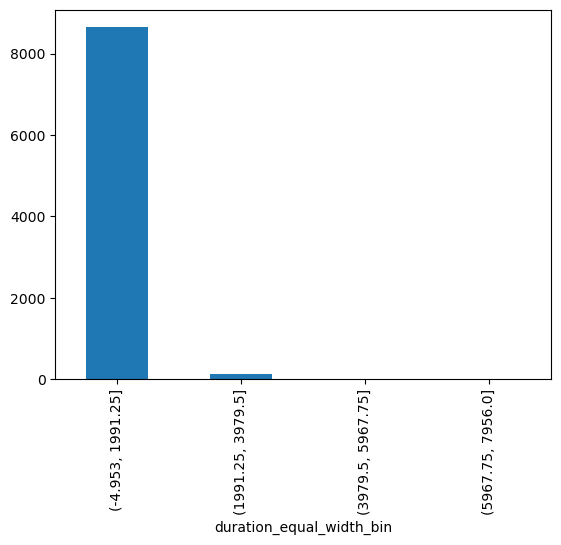

In [13]:
# put your answer here
binCounts = df_clean["duration_equal_width_bin"].value_counts().sort_index()
print(binCounts)
print(binCounts.plot(kind='bar'))
print()
print("Categories:")
print(dur_width_bins.dtype.categories)

Apply equal-frequency binning to dur into 5 bins. Store as `dur_quantile_bins`.

- Use `pandas.qcut()` to divide duration_minutes into 4 equal-frequency bins.
- Add the result as a new column named:
`duration_equal_freq_bin`

***ANSWERS:***

1. What are the bin edges produced by equal-width binning?
2. How many movies fall into each bin?

The bin edges produced along with the movies that fell into them are:
- (2.999, 92.0]      2263
- (92.0, 112.0]      2212
- (112.0, 468.0]     3446
- (468.0, 7956.0]     883

NOTE: 3rd bin spikes due to the imputed season where 1 season is equal to a flat 468 minutes. With many season 1 being put in the lower bin (bin 3 `(112.0, 468.0]`)

In [14]:
s1Dur = len(df_clean[df_clean["duration"] == "1 Season"])
nonS1Dur = len(df_clean[(df_clean["duration_minutes"] < 468) & (df_clean["duration_minutes"] > 112)])

print(f"Number of 1 Season durations: {s1Dur}")
print(f"Number of durations between 113 and 468 minutes: {nonS1Dur}")
print(f"Difference: {s1Dur - nonS1Dur}")
print(f"Combined total: {s1Dur + nonS1Dur}")

Number of 1 Season durations: 1793
Number of durations between 113 and 468 minutes: 1653
Difference: 140
Combined total: 3446


In [15]:
# put your answer here
dur_quantile_bins = pd.qcut(df_clean["duration_minutes"], q=4)
df_clean.loc[:, "duration_equal_freq_bin"] = dur_quantile_bins
print(dur_quantile_bins)

0         (2.999, 92.0]
1       (468.0, 7956.0]
2        (112.0, 468.0]
3        (112.0, 468.0]
4       (468.0, 7956.0]
             ...       
8802     (112.0, 468.0]
8803    (468.0, 7956.0]
8804      (2.999, 92.0]
8805      (2.999, 92.0]
8806      (92.0, 112.0]
Name: duration_minutes, Length: 8804, dtype: category
Categories (4, interval[float64, right]): [(2.999, 92.0] < (92.0, 112.0] < (112.0, 468.0] < (468.0, 7956.0]]


Describe the characteristics of each bin

- What are the bin ranges produced by equal-frequency binning?
- How many movies fall into each bin? Are they nearly equal?

duration_equal_freq_bin
(2.999, 92.0]      2263
(92.0, 112.0]      2212
(112.0, 468.0]     3446
(468.0, 7956.0]     883
Name: count, dtype: int64
Axes(0.125,0.11;0.775x0.77)

Categories:
IntervalIndex([(2.999, 92.0], (92.0, 112.0], (112.0, 468.0], (468.0, 7956.0]], dtype='interval[float64, right]')


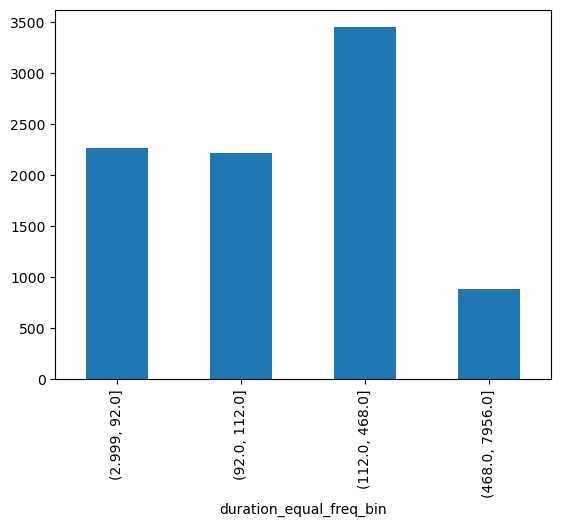

In [16]:
# put your answer here
binFeqCounts = df_clean["duration_equal_freq_bin"].value_counts().sort_index()
print(binFeqCounts)
print(binFeqCounts.plot(kind='bar'))
print()
print("Categories:")
print(dur_quantile_bins.dtype.categories)

## 7. KNN Before & After Scaling


Create a feature matrix X using any two numeric columns and a target y (e.g., classification by genre or type). Create a train/test split.

In [17]:
x = df_clean[["release_year", "duration_minutes"]]
y = df_clean["type"]

xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2, random_state=42)

Train a KNN classifier without scaling. Store accuracy in acc_raw.

In [18]:
# put your answer here
knnRaw = KNN()
knnRaw.fit(xTrain, yTrain)
yPredRaw = knnRaw.predict(xTest)
accuracyRaw = accuracy_score(yTest, yPredRaw)

print(f"Accuracy with raw features: {accuracyRaw:.4f}")

Accuracy with raw features: 1.0000


Scale `X` using either Min–Max or Standardization, retrain KNN, and store accuracy in acc_scaled.

In [19]:
# put your answer here
scaler = StandardScaler()
xTrainScaled = scaler.fit_transform(xTrain)
xTestScaled = scaler.transform(xTest)

knnScaled = KNN()
knnScaled.fit(xTrainScaled, yTrain)
yPredScaled = knnScaled.predict(xTestScaled)
accuracyScaled = accuracy_score(yTest, yPredScaled)

print(f"Accuracy with scaled features: {accuracyScaled:.4f}")

Accuracy with scaled features: 0.9977


Did scaling improve accuracy? Explain why.

***ANSWER:***

It did not. My take is that because of the fixed imputations for the seasons (1 season == 468 minutes) created isolated clusters that easily dictates which side is the `Movie` types and the other as `TV Show`.

The scatter plot below shows the split of said types in the dataset with the `release_year` as its `X` axis and `duration_minutes` (the imputed values) at its `Y` axis.

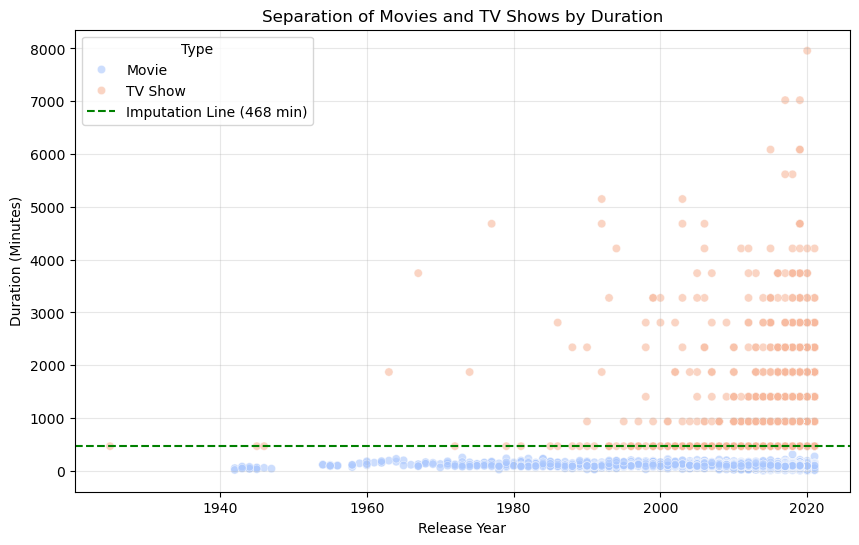

In [20]:
plt.figure(figsize=(10, 6))

sns.scatterplot(
    data=df_clean,
    x="release_year",
    y="duration_minutes",
    hue="type",
    palette="coolwarm",
    alpha=0.6
)

plt.axhline(
	y=468,
	color="green",
	linestyle="--",
	label="Imputation Line (468 min)"
)

plt.title('Separation of Movies and TV Shows by Duration')
plt.xlabel('Release Year')
plt.ylabel('Duration (Minutes)')
plt.legend(title='Type')
plt.grid(True, alpha=0.3)

plt.show()

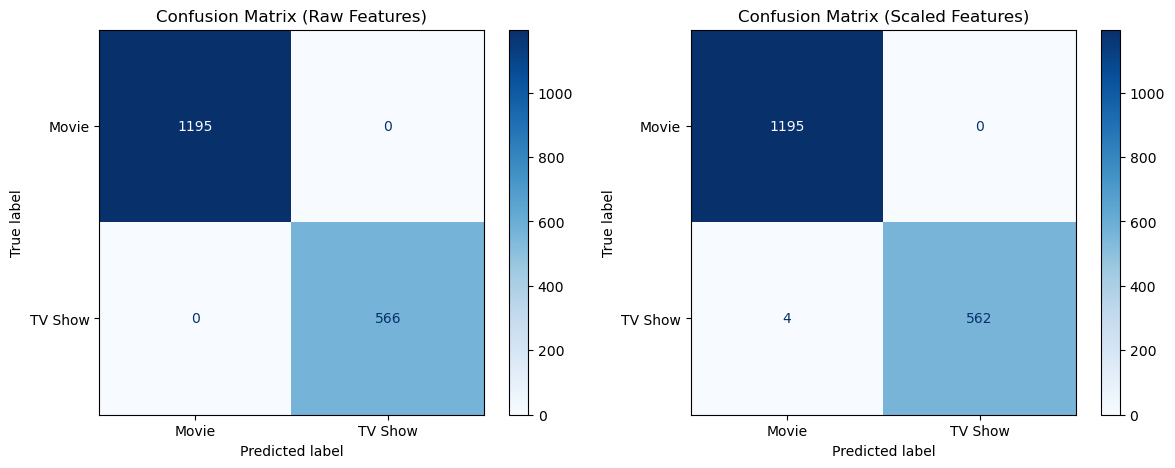

In [21]:
# put your answer here
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

cmr = confusion_matrix(yTest, yPredRaw)
cmdr = ConfusionMatrixDisplay(cmr, display_labels=knnRaw.classes_)
cmdr.plot(ax=ax[0], cmap=plt.cm.Blues)
cmdr.ax_.set_title("Confusion Matrix (Raw Features)")

cms = confusion_matrix(yTest, yPredScaled)
cmds = ConfusionMatrixDisplay(cms, display_labels=knnScaled.classes_)
cmds.plot(ax=ax[1], cmap=plt.cm.Blues)
cmds.ax_.set_title("Confusion Matrix (Scaled Features)")

plt.show()